In [2]:
from json import dumps

import torch

from deepproblog.dataset import DataLoader
from deepproblog.engines import ApproximateEngine, ExactEngine
from deepproblog.evaluate import get_confusion_matrix
from deepproblog.examples.MNIST.data import MNIST_train, MNIST_test, addition, datasets
from deepproblog.examples.MNIST.network import MNIST_Net
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.train import train_model
import os
import sys

In [3]:
method = "exact"
N = 1
script_dir = os.getcwd()
print("script dir: ", script_dir)

script dir:  c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code


In [4]:
train_set = addition(N, "train")
test_set = addition(N, "test")

In [5]:
print(type(train_set[0][0][0]))
print(type(train_set[0][1][0]))
print(type(train_set[0][2]))
print(type(train_set[0]))


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'int'>
<class 'tuple'>


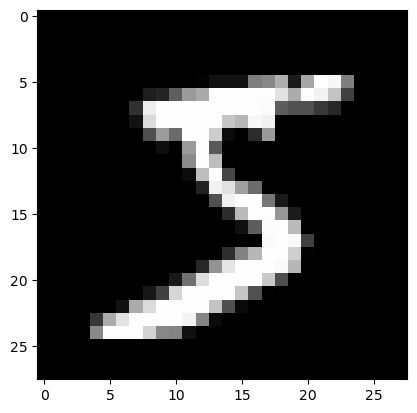

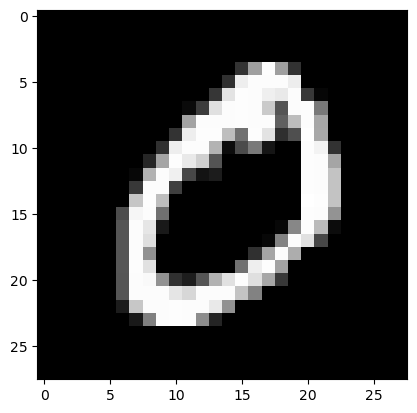

Label sum: 5


In [6]:
first_digit_tensor = train_set[0][0][0]
second_digit_tensor = train_set[0][1][0]
label_sum = train_set[0][2]

# show the tensors as image
import matplotlib.pyplot as plt
plt.imshow(first_digit_tensor.squeeze(), cmap="gray")
plt.show()

plt.imshow(second_digit_tensor.squeeze(), cmap="gray")
plt.show()

print("Label sum:", label_sum)


In [7]:
type(datasets["train"])

torchvision.datasets.mnist.MNIST

In [8]:
train_set.data[0]

[[0], [1]]

In [9]:
# Let's test what gets passed to MNIST_train.__getitem__
print("Testing MNIST_train with tuple (the correct way):")
try:
    result1 = MNIST_train[(0,)]  # Tuple - this should work
    print("MNIST_train[(0,)] works!")
    print("Type:", type(result1))
    print("Shape:", result1.shape)
except Exception as e:
    print("MNIST_train[(0,)] failed:", e)

print("\nTesting MNIST_train[0] (direct integer - should fail):")
try:
    result2 = MNIST_train[0]  # Integer - this should fail
    print("MNIST_train[0] works! Type:", type(result2))
except Exception as e:
    print("MNIST_train[0] failed:", e)

print("\nTesting MNIST_train with list:")
try:
    result3 = MNIST_train[[0]]  # List
    print("MNIST_train[[0]] works! Shape:", result3.shape)
except Exception as e:
    print("MNIST_train[[0]] failed:", e)

Testing MNIST_train with tuple (the correct way):
MNIST_train[(0,)] works!
Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 28, 28])

Testing MNIST_train[0] (direct integer - should fail):
MNIST_train[0] failed: 'int' object is not subscriptable

Testing MNIST_train with list:
MNIST_train[[0]] works! Shape: torch.Size([1, 28, 28])


In [10]:
train_set[0]

([tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -

In [11]:
# MNIST Indices
train_set.data[0]

[[0], [1]]

In [12]:
train_set._get_label(0)

5

In [ ]:
# High level
import itertools
import json
import random
from pathlib import Path
from typing import Callable, List, Iterable, Tuple

import torchvision
import torchvision.transforms as transforms
from problog.logic import Term, list2term, Constant
from torch.utils.data import Dataset as TorchDataset

from deepproblog.dataset import Dataset
from deepproblog.query import Query

_DATA_ROOT = script_dir

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

datasets = {
    "train": torchvision.datasets.MNIST(
        root=str(_DATA_ROOT), train=True, download=True, transform=transform
    ),
    "test": torchvision.datasets.MNIST(
        root=str(_DATA_ROOT), train=False, download=True, transform=transform
    ),
}

def digits_to_number(digits: Iterable[int]) -> int:
    number = 0
    for d in digits:
        number *= 10
        number += d
    return number

class MNISTOperator(Dataset, TorchDataset):
    def __getitem__(self, index: int) -> Tuple[list, list, int]:
        # get the two images
        l1, l2 = self.data[index]
        # get their sum as label
        label = self._get_label(index)
        l1 = [self.dataset[x][0] for x in l1]
        l2 = [self.dataset[x][0] for x in l2]
        return l1, l2, label

    def __init__(
        self,
        dataset_name: str,
        function_name: str,
        operator: Callable[[List[int]], int],
        size=1,
        arity=2,
        seed=None,
    ):
        """Generic dataset for operator(img, img) style datasets.

        :param dataset_name: Dataset to use (train, val, test)
        :param function_name: Name of Problog function to query.
        :param operator: Operator to generate correct examples
        :param size: Size of numbers (number of digits)
        :param arity: Number of arguments for the operator
        :param seed: Seed for RNG
        """
        super(MNISTOperator, self).__init__()
        assert size >= 1
        assert arity >= 1
        self.dataset_name = dataset_name
        self.dataset = datasets[self.dataset_name]
        self.function_name = function_name
        self.operator = operator
        self.size = size
        self.arity = arity
        self.seed = seed
        mnist_indices = list(range(len(self.dataset)))
        if seed is not None:
            rng = random.Random(seed)
            rng.shuffle(mnist_indices)
        dataset_iter = iter(mnist_indices)
        # Build list of examples (mnist indices)
        self.data = []
        try:
            while dataset_iter:
                self.data.append(
                    [
                        [next(dataset_iter) for _ in range(self.size)]
                        for _ in range(self.arity)
                    ]
                )
        except StopIteration:
            pass

    def to_file_repr(self, i):
        """Old file represenation dump. Not a very clear format as multi-digit arguments are not separated"""
        return f"{tuple(itertools.chain(*self.data[i]))}\t{self._get_label(i)}"

    def to_json(self):
        """
        Convert to JSON, for easy comparisons with other systems.

        Format is [EXAMPLE, ...]
        EXAMPLE :- [ARGS, expected_result]
        ARGS :- [MULTI_DIGIT_NUMBER, ...]
        MULTI_DIGIT_NUMBER :- [mnist_img_id, ...]
        """
        data = [(self.data[i], self._get_label(i)) for i in range(len(self))]
        return json.dumps(data)

    def to_query(self, i: int) -> Query:
        """Generate queries"""
        mnist_indices = self.data[i]
        expected_result = self._get_label(i)

        # Build substitution dictionary for the arguments
        subs = dict()
        var_names = []
        for i in range(self.arity):
            inner_vars = []
            for j in range(self.size):
                t = Term(f"p{i}_{j}")
                subs[t] = Term(
                    "tensor",
                    Term(
                        self.dataset_name,
                        Constant(mnist_indices[i][j]),
                    ),
                )
                inner_vars.append(t)
            var_names.append(inner_vars)

        # Build query
        if self.size == 1:
            return Query(
                Term(
                    self.function_name,
                    *(e[0] for e in var_names),
                    Constant(expected_result),
                ),
                subs,
            )
        else:
            return Query(
                Term(
                    self.function_name,
                    *(list2term(e) for e in var_names),
                    Constant(expected_result),
                ),
                subs,
            )

    def _get_label(self, i: int):
        mnist_indices = self.data[i]
        # Figure out what the ground truth is, first map each parameter to the value:
        ground_truth = [
            digits_to_number(self.dataset[j][1] for j in i) for i in mnist_indices
        ]
        # Then compute the expected value:
        expected_result = self.operator(ground_truth)
        return expected_result

    def __len__(self):
        return len(self.data)
    
def addition(n: int, dataset: str, seed=None):
    """Returns a dataset for binary addition"""
    return MNISTOperator(
        dataset_name=dataset,
        function_name="addition" if n == 1 else "multi_addition",
        operator=sum,
        size=n,
        arity=2,
        seed=seed,
)
    
train_setje = addition(N, "train")

train_setje.to_query(0)

(1.0::addition(p0_0,p1_0,5), {p0_0: tensor(train(0)), p1_0: tensor(train(1))})